<a href="https://colab.research.google.com/github/paulaleite/aprendizagemDeMaquinaa2022/blob/main/Unsupervised_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Anomaly Detection
## *Paula Torales Leite*
### Case: Numenta Anomaly Benchmark (NAB)

Dado a solução inicial disponível no Kaggle, será feita uma uma análise de detecção de anomalia com os algoritmos abordados em aula. Além disso, vou verificar a descoberta de agrupamento com alguma das medidas de validação de agrupamento e justificar as escolhas. Para o caso do DBSCAN, vou justificar as parametrizações escolhidas.

## Importações

In [70]:
# Bibliotecas padrões
import pandas as pd
import numpy as np

# Bibliotecas de Visualização
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from numpy import random, where

# Modelagem e Aprendizagem de Máquina
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import davies_bouldin_score

# RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

Funções para mais para frente

In [2]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        # distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

## Interpretação dos Dados

Extração de Dados

In [3]:
df = pd.read_csv("ambient_temperature_system_failure.csv")

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [5]:
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


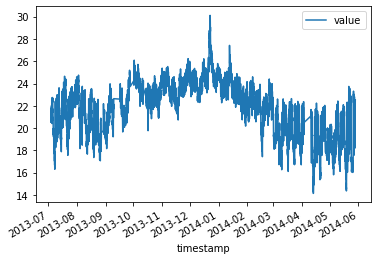

In [6]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

Extraindo features

In [7]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [9]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

<ipython-input-9-c3d0082d3df0>:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


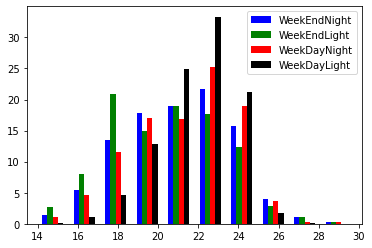

In [10]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

Com isso, foi possível ver que a temperatura é mais estável durante o dia, em dias úteis.

## Modelos

Os pontos que estão distantes do cluster são pontos com combinação usual de feições. Esses pontos como anomalias.

In [11]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

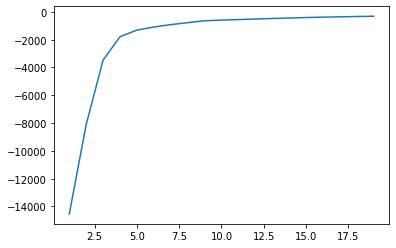

In [12]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [13]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

9     716
12    661
2     613
7     609
3     599
6     588
8     576
0     534
11    437
10    358
13    356
14    347
5     330
1     305
4     238
Name: cluster, dtype: int64

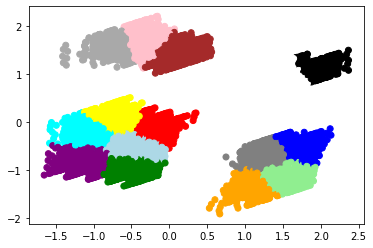

In [14]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [15]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

<ipython-input-2-4933b9bd0355>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


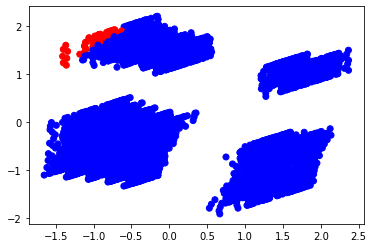

In [16]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

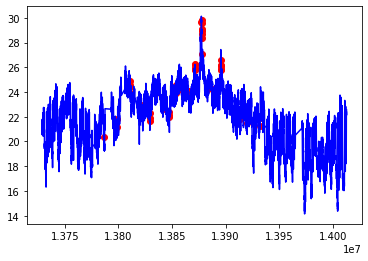

In [17]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


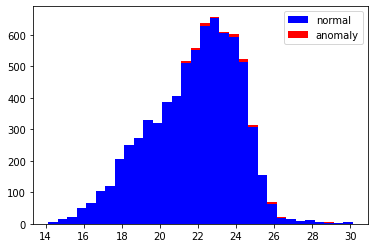

In [18]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

O método Cluster detectou a baixa temperatura no final do registro como excepcionalmente baixa. Não detecta a foto de temperatura mais alta

Use para dados contextuais e anomalias coletivas (não ordenadas).¶
Separaremos os dados por (o que pensamos) categorias importantes. Ou podemos separar os dados com base em cluster diferente (método 2.3). Em seguida, encontramos outliers (repartição gaussiana, unimodal) por categorias de forma independente.

In [19]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

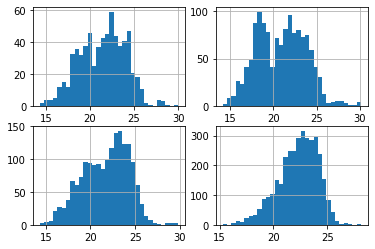

In [20]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [21]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


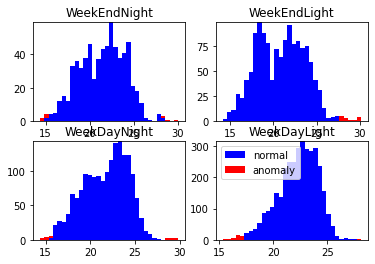

In [22]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [23]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

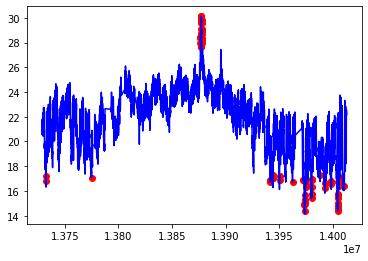

In [24]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


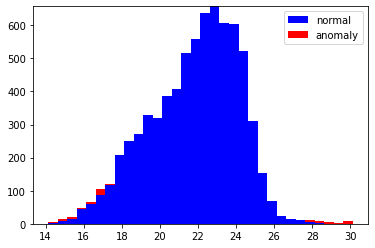

In [25]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Boas detecções de valores extremos e separação de contexto adicionam alguma precisão à detecção.

### Markov chains

In [26]:
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

Detecta uma sequência incomum, mas não um valor extremo. Mais difícil avaliar a relevância deste exemplo. O tamanho da sequência (5) deve corresponder a algum ciclo interessante.

###  Isolation Forest

In [101]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
clusterData = model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7195
1      72
Name: anomaly25, dtype: int64


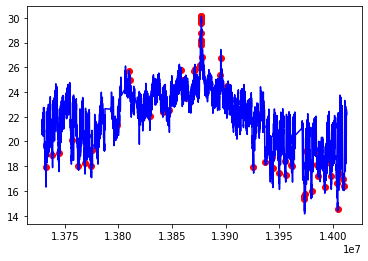

In [28]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


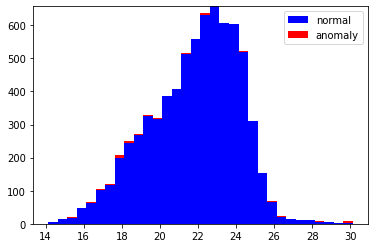

In [29]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

### One class SVM

In [86]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
modelo = model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


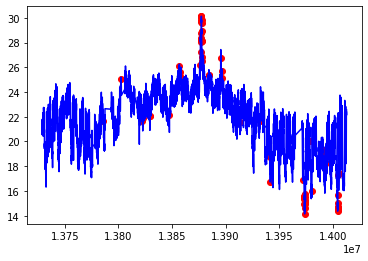

In [31]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


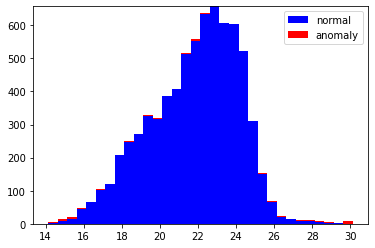

In [32]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Dá resultado semelhante à floresta de isolamento, mas encontra algumas anomalias nos valores médios. Difícil saber se é relevante.

### RNN

In [33]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [34]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [41]:
model = Sequential()

model.add(LSTM(
    50,
    input_dim=x_train.shape[-1],
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.005843400955200195


In [43]:
# Train Model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=30,
    validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 13s 3s/step - loss: 0.6669 - val_loss: 0.7115
Epoch 2/30
2/2 [==============================] - 5s 2s/step - loss: 0.1957 - val_loss: 0.3905
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 0.1545 - val_loss: 0.2626
Epoch 4/30
2/2 [==============================] - 5s 2s/step - loss: 0.1190 - val_loss: 0.2215
Epoch 5/30
2/2 [==============================] - 8s 4s/step - loss: 0.1059 - val_loss: 0.1955
Epoch 6/30
2/2 [==============================] - 5s 2s/step - loss: 0.0954 - val_loss: 0.1907
Epoch 7/30
2/2 [==============================] - 5s 2s/step - loss: 0.0921 - val_loss: 0.1949
Epoch 8/30
2/2 [==============================] - 5s 2s/step - loss: 0.0922 - val_loss: 0.2106
Epoch 9/30
2/2 [==============================] - 5s 2s/step - loss: 0.0904 - val_loss: 0.1934
Epoch 10/30
2/2 [==============================] - 5s 2s/step - loss: 0.0882 - val_loss: 0.1751
Epoch 11/30
2/2 [==============================]

In [44]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

32/32 [==============================] - 4s 30ms/step


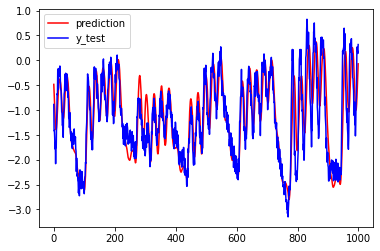

In [45]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [46]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


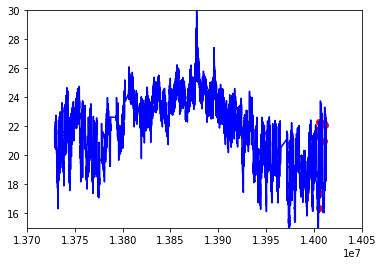

In [47]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


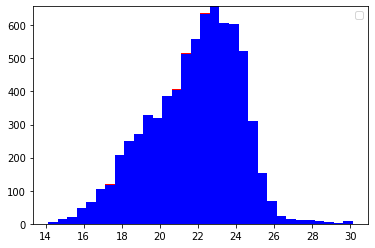

In [48]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

### DBSCAN

In [111]:
model = DBSCAN(eps = 0.3, min_samples = 30).fit(data)

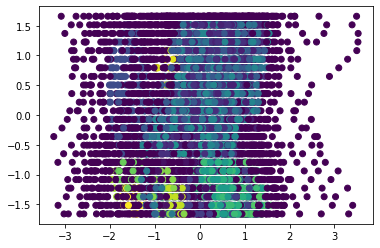

In [112]:
labels = model.labels_
plt.scatter(data[0], data[1], c = labels)

In [113]:
# outliers dataframe
outliers = data[model.labels_ == -1]
print(outliers)

             0         1         2         3        4
23   -0.139497  1.658855 -1.414798  0.005769  0.62132
24    0.023618 -1.661537 -1.414798  0.510868  0.62132
27   -0.235107 -1.228442 -1.414798  0.510868  0.62132
29   -0.351635 -0.939713 -1.414798  0.510868  0.62132
30   -0.586984 -0.795348 -1.414798  0.510868  0.62132
...        ...       ...       ...       ...      ...
7234 -1.790459 -0.650983  0.706815 -1.004429  0.62132
7235 -1.568199 -0.506618  0.706815 -1.004429  0.62132
7250 -0.531047  1.658855 -1.414798 -1.004429  0.62132
7257 -1.520622 -0.795348 -1.414798 -0.499330  0.62132
7258 -1.317700 -0.650983  0.706815 -0.499330  0.62132

[2549 rows x 5 columns]


#### Avalição de Desempenho

In [114]:
db_index = davies_bouldin_score(data, labels)
print(db_index)

1.732271376583915


## Resultados
Como foi possível visualizar através dos diversos testes executados.
Buscou-se calcular o Índice de Davies-Bouldin e chegou-se a 1.732271376583915 com o DBSCAN. Sendo que é necessário um número pequeno desse índice para atingir resultados bons, adaptou-se os valores usados no próprio DBSCAN.
Os resultados anteriores haviam apontado para a análise de que poderiam existir vários objetos dentro de um único cluster, sendo assim, foi-se testando com valores variados, porém altos, o min_samples, para que ele tivesse clusters mais próximos do esperado.
Além disso, sendo que existiam muitos valores na base, poderia-se considerar que a distância entre os objetos poderia ser pequena.
Assim, validando, chegou-se ao valor de epsilon de 0.3 e 30 para o número mínimo de samples.
